In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle
import datetime as date
import math
import seaborn as sns
sns.set()


from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
with open('modeling_data','rb') as read_file:
    df = pickle.load(read_file)

In [3]:
df.head()

,weight,camera,price,screen_size,length,width,thickness,battery,memory,RAM
1,169.0,13.0,250.0,5.5,153.8,75.6,8.5,4080.0,32000.0,3000.0
2,166.0,13.0,230.0,5.5,153.3,78.8,8.5,4020.0,32000.0,3000.0
3,125.0,8.0,110.0,5.0,145.7,71.2,8.4,2000.0,8000.0,1000.0
5,150.0,21.0,220.0,5.5,156.5,75.9,8.4,2870.0,32000.0,3000.0
6,142.0,5.0,110.0,4.5,136.0,66.5,9.6,2000.0,8000.0,1000.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2819
Data columns (total 10 columns):
weight         2344 non-null float64
camera         2344 non-null float64
price          2344 non-null float64
screen_size    2344 non-null float64
length         2344 non-null float64
width          2344 non-null float64
thickness      2344 non-null float64
battery        2344 non-null float64
memory         2344 non-null float64
RAM            2344 non-null float64
dtypes: float64(10)
memory usage: 201.4 KB


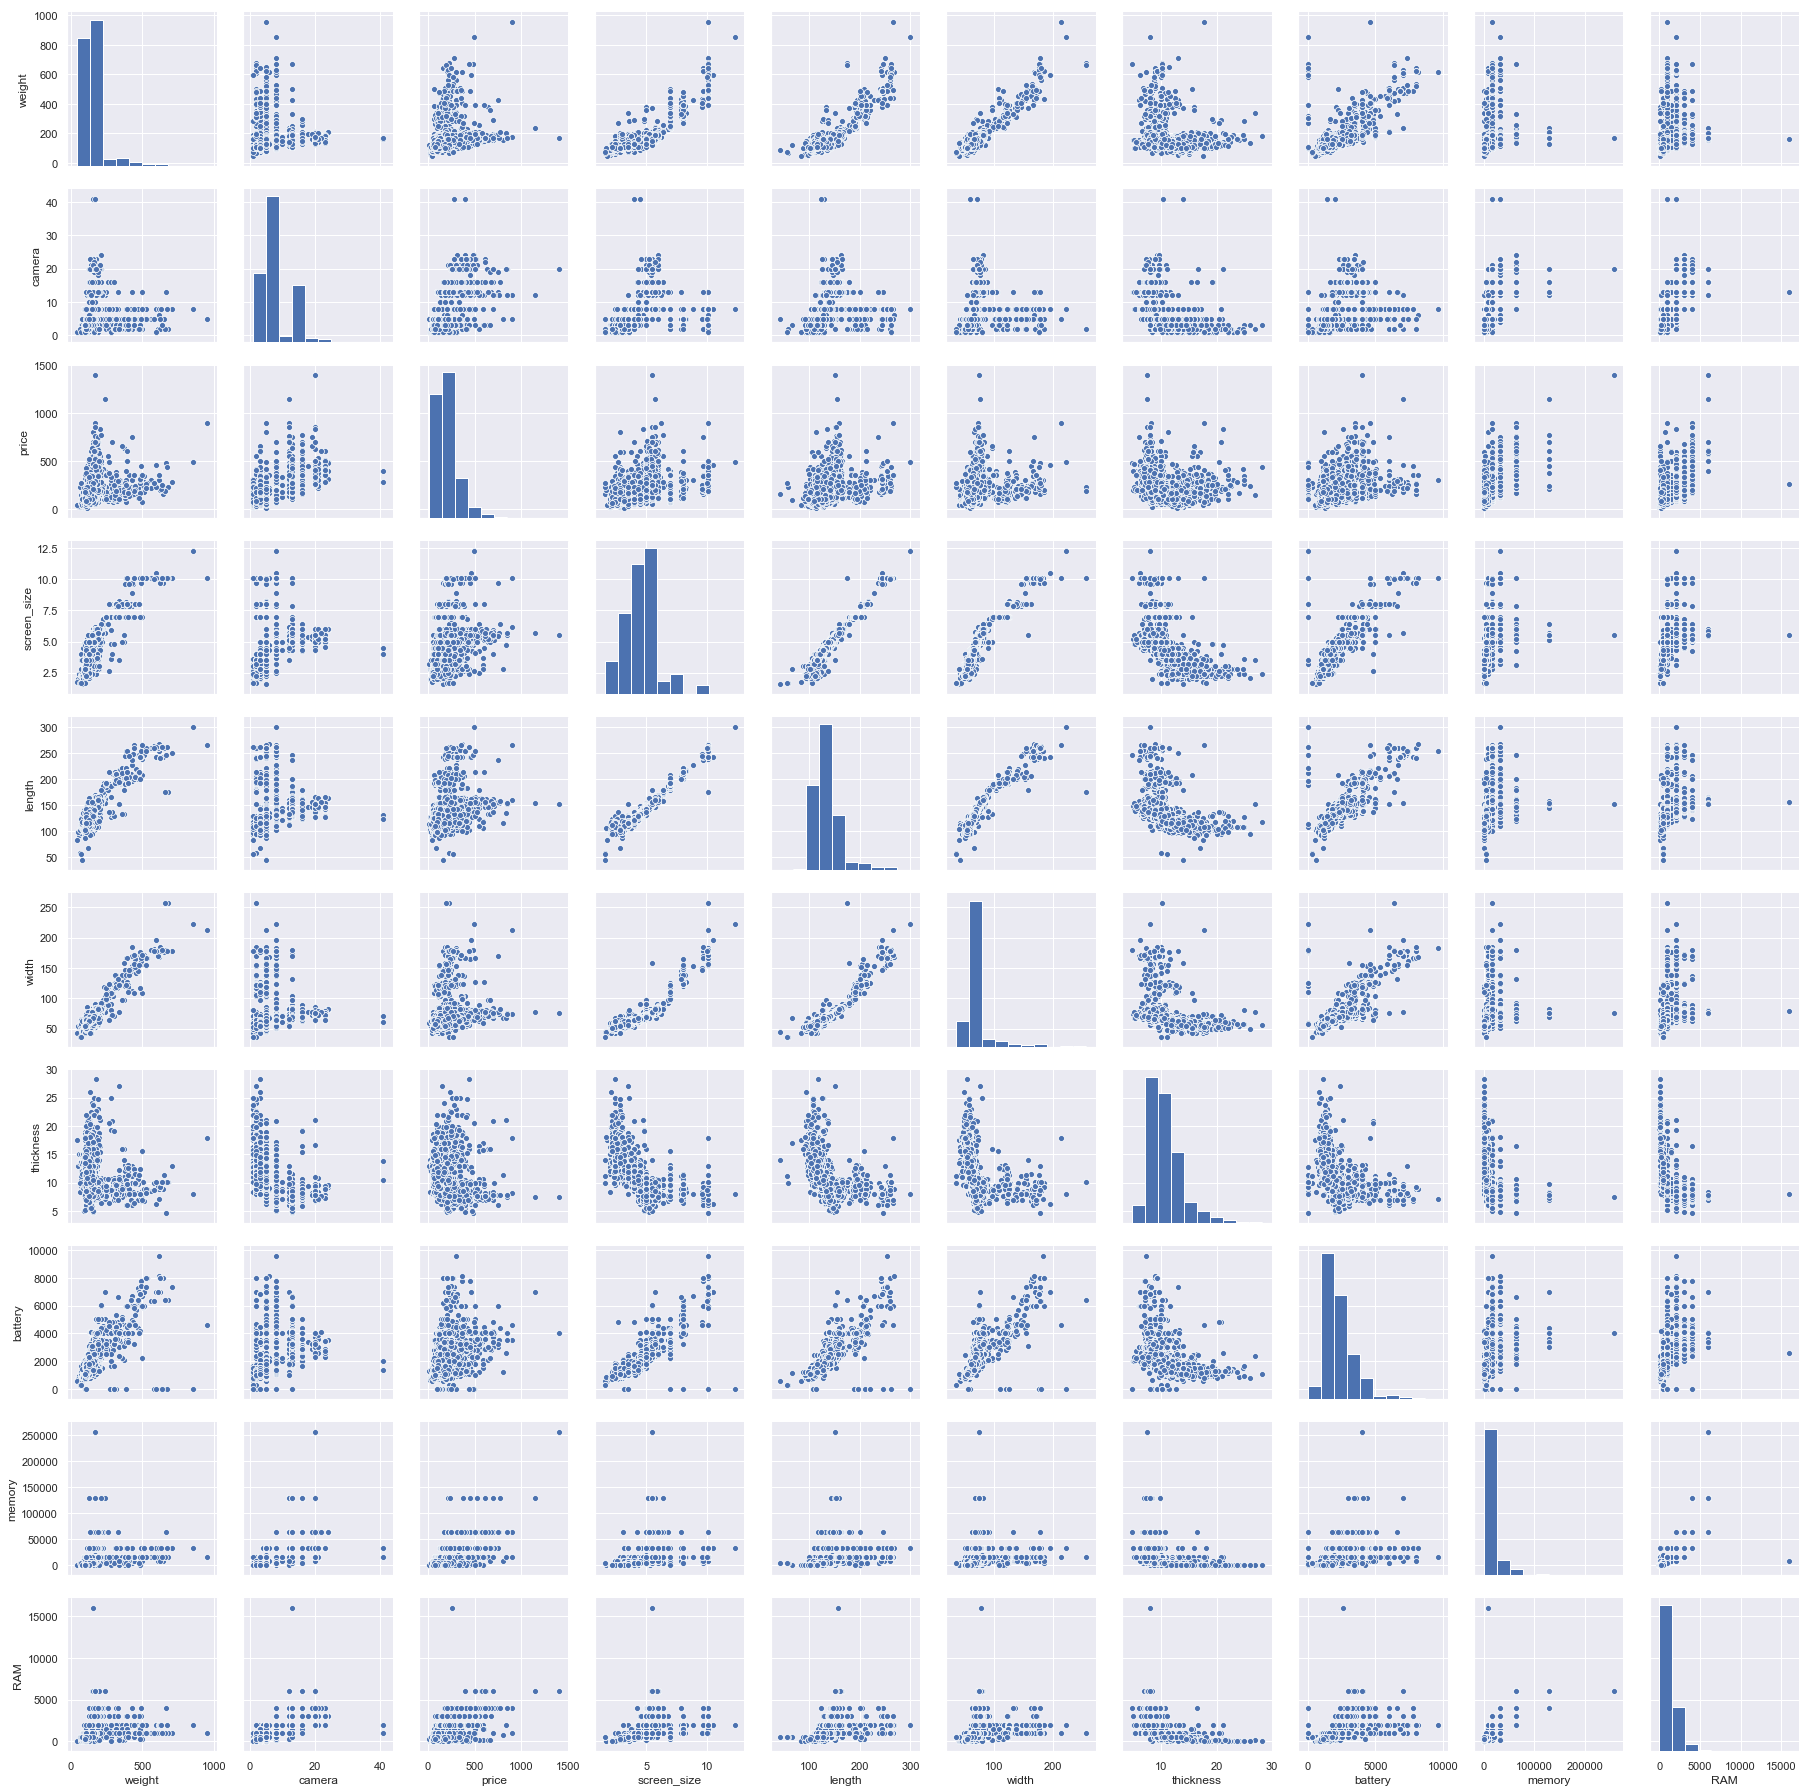

In [5]:
sns.pairplot(df)

In [6]:
df.columns

Index(['weight', 'camera', 'price', 'screen_size', 'length', 'width',
       'thickness', 'battery', 'memory', 'RAM'],
      dtype='object')

In [7]:
df['log_price'] = np.log(df['price'])

In [8]:
# using statsmodel OLS
y_ols, X_ols = patsy.dmatrices('log_price ~ weight + camera + screen_size + length + width + thickness + battery + memory + RAM',
                               data=df, return_type="dataframe")


model = sm.OLS(y_ols, X_ols)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     230.4
Date:                Sun, 21 Apr 2019   Prob (F-statistic):          1.91e-314
Time:                        12:40:07   Log-Likelihood:                -1247.9
No. Observations:                2344   AIC:                             2516.
Df Residuals:                    2334   BIC:                             2573.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.0173      0.138     29.176      0.000       3.747       4.287
weight          0.0023      0.000      5.522      0.000       0.001       0.003
camera          0.0510      0.003     16.338      0.000       0.045       0.057
screen_size     0.0728      0.030      2.431      0.015       0.014       0.132
length         -0.0015      0.001     -1.112      0.266      -0.004       0.001
width          -0.0061      0.002     -3.453      0.001      -0.010      -0.003
thickness       0.0435      0.006      7.812      0.000       0.033       0.054
battery        2.5e-05    1.4e-05      1.786      0.074   -2.45e-06    5.25e-05
memory       7.096e-06   8.72e-07      8.137      0.000    5.39e-06    8.81e-06
RAM          6.935e-05   1.69e-05      4.111      0.000    3.63e-05       0.000
==============================================================================
Omnibus:                       39.808   Durbin-Watson:                   1.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.993
Skew:                           0.015   Prob(JB):                     1.91e-17
Kurtosis:                       3.887   Cond. No.                     3.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

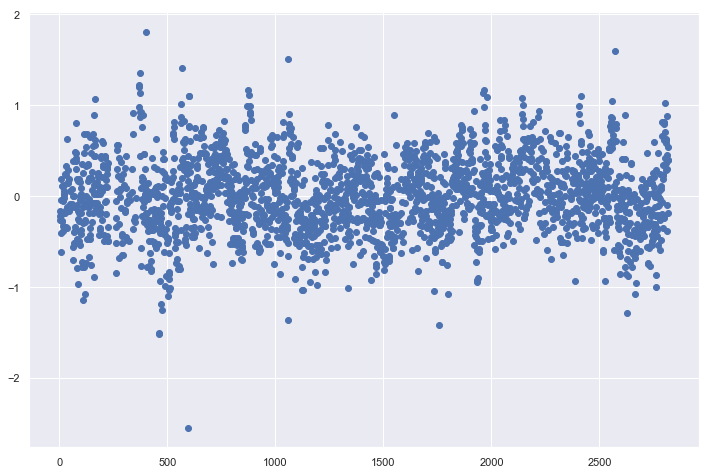

In [9]:
fit.resid.plot(style='o', figsize=(12,8));

In [10]:
def split_and_validate(X, y):
    
    #train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=30)
    
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.3f}') 
        

In [11]:
X_t = df.loc[:,['weight', 'camera', 'screen_size', 'length', 'width',
               'thickness', 'battery', 'memory', 'RAM']]
       

y_t = df['log_price']


split_and_validate(X_t, y_t)


Validation R^2 score was: 0.5107933852019382
Feature coefficient results: 

weight : 0.003
camera : 0.049
screen_size : 0.059
length : -0.001
width : -0.007
thickness : 0.043
battery : 0.000
memory : 0.000
RAM : 0.000


In [12]:
df_trans1 = df.copy()
df_trans1['log_memory'] = np.log(df_trans1['memory'])

X_t = df_trans1.loc[:,['weight', 'camera', 'screen_size', 'length', 'width',
                       'thickness', 'battery', 'log_memory', 'RAM']]
y_t = df_trans1['log_price']

split_and_validate(X_t, y_t)


Validation R^2 score was: 0.4860234767784033
Feature coefficient results: 

weight : 0.003
camera : 0.047
screen_size : -0.031
length : 0.001
width : -0.005
thickness : 0.051
battery : 0.000
log_memory : 0.053
RAM : 0.000


This decreases my R^2 significantly

In [13]:
df_trans2 = df.copy()
df_trans2['sqrt_memory'] = np.sqrt(df_trans2['memory'])

X_t = df_trans2.loc[:,['weight', 'camera', 'screen_size', 'length', 'width',
                       'thickness', 'battery', 'sqrt_memory', 'RAM']]
y_t = df_trans2['log_price']

split_and_validate(X_t, y_t)


Validation R^2 score was: 0.517059255549657
Feature coefficient results: 

weight : 0.002
camera : 0.045
screen_size : 0.010
length : -0.000
width : -0.006
thickness : 0.049
battery : 0.000
sqrt_memory : 0.003
RAM : 0.000


An increase of .007 is not enough to justify the transformation

In [14]:
df_trans3 = df.copy()
df_trans3['sqrt_RAM'] = np.sqrt(df_trans3['RAM'])

X_t = df_trans3.loc[:,['weight', 'camera', 'screen_size', 'length', 'width',
                       'thickness', 'battery', 'memory', 'sqrt_RAM']]
y_t = df_trans3['log_price']

split_and_validate(X_t, y_t)


Validation R^2 score was: 0.5160758621942119
Feature coefficient results: 

weight : 0.002
camera : 0.048
screen_size : 0.024
length : -0.000
width : -0.006
thickness : 0.047
battery : 0.000
memory : 0.000
sqrt_RAM : 0.008


An increase of .006 is not enough to justify the transformation

In [20]:
df_trans4 = df.copy()
df_trans4['log_RAM'] = np.log(df_trans4['RAM'])

X_t = df_trans4.loc[:,['weight', 'camera', 'screen_size', 'length', 'width',
                       'thickness', 'battery', 'memory', 'log_RAM']]
y_t = df_trans4['log_price']

split_and_validate(X_t, y_t)


Validation R^2 score was: 0.514481618261366
Feature coefficient results: 

weight : 0.002
camera : 0.053
screen_size : 0.025
length : 0.000
width : -0.006
thickness : 0.047
battery : 0.000
memory : 0.000
log_RAM : 0.055


An increase of .004 is not enough to justify the transformation

In [22]:
df_trans5 = df.copy()
df_trans5['log_camera'] = np.log(df_trans5['camera'])

X_t = df_trans5.loc[:,['weight', 'log_camera', 'screen_size', 'length', 'width',
                       'thickness', 'battery', 'memory', 'RAM']]
y_t = df_trans5['log_price']

split_and_validate(X_t, y_t)


Validation R^2 score was: 0.5156947494320883
Feature coefficient results: 

weight : 0.002
log_camera : 0.394
screen_size : -0.036
length : 0.001
width : -0.002
thickness : 0.058
battery : 0.000
memory : 0.000
RAM : 0.000


In [24]:
df_trans6 = df.copy()
df_trans6['square_camera'] = df_trans6['camera']**2

X_t = df_trans6.loc[:,['weight', 'square_camera', 'screen_size', 'length', 'width',
                       'thickness', 'battery', 'memory', 'RAM']]
y_t = df_trans6['log_price']

split_and_validate(X_t, y_t)


Validation R^2 score was: 0.4665373555647384
Feature coefficient results: 

weight : 0.003
square_camera : 0.001
screen_size : 0.135
length : -0.002
width : -0.012
thickness : 0.036
battery : 0.000
memory : 0.000
RAM : 0.000


Many more transformations were further tested, using square, log, and square root transformations. However, none provided great score increases. In the end, only the log of price was chosen to be included to fit linear regression assumptions.

In [16]:
df.head(3)

,weight,camera,price,screen_size,length,width,thickness,battery,memory,RAM,log_price
1,169.0,13.0,250.0,5.5,153.8,75.6,8.5,4080.0,32000.0,3000.0,5.521461
2,166.0,13.0,230.0,5.5,153.3,78.8,8.5,4020.0,32000.0,3000.0,5.438079
3,125.0,8.0,110.0,5.0,145.7,71.2,8.4,2000.0,8000.0,1000.0,4.700480


In [17]:
df = df.reset_index()
df.drop(['index'], axis=1, inplace=True)

In [19]:
with open('final_data', 'wb') as to_write:
    pickle.dump(df, to_write)